# Eletronic House AB Testing

## Solution Planning

### Methodology

1. Hyphotesis testing
2. A/B testing

### Experiment Design

1. Hyphoteses formulation
    * Null Hyphotesis
    * Alternative Hypothesis
    * One-Tailed Test or Two-Tailed Test
    * Confidence Index definition
2. Variable Definition
    * Definition of evaluation metric or dependent variable
3. Separing groups
    * Control group
    * Treatment group
    * Definition of sample size

### Data Collection and Preparation 

1. Data Collection
2. Data Preparation
3. Groups conversions

### Testing Hypotheses

1. Statistical Inference method definition
2. p-value calculation

### Conclusions

1. p-value interpretation
2. Initial hypotheses validation
3. Conclusion
4. Sales potential of the new page
5. Potential income of the product

## 0.0. Imports

In [20]:
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats import api as sms
from scipy.stats import ttest_ind

## 1.0. Experiment Design

**Objective**: Define whether checkout page auto-fill is better than manual fill-in

**Success Metric**: Average GMV (Gross Margin Revenue)

GRP A = Automatic filling

GRP B = Manual filling

### 1.1. Experiment Hypothesis

H0: Avg. GMV A = Avg. GMV B

HA: Avg. GMV A != Avg. GMV B

### 1.2. Define Sample size

[Controlled Experiments on the web: survey and practical guide](https://ai.stanford.edu/~ronnyk/2009controlledExperimentsOnTheWebSurvey.pdf)

Sample size will be calculated using the paper methodology.

The average value spent from Brazilians is 1902.82 and its standard deviation is 1398.89. 

The minimum sample size we need for each group is 3395.

In [2]:
init_metric = 1902.86 # avg GMV
end_metric = init_metric * (1 + 0.05) # avg GMV lift
std_metric = 1398.89

effect_size = (end_metric - init_metric) / std_metric

sample_size = sms.tt_ind_solve_power(effect_size, alpha = 0.05, power = 0.80)

sample_size = np.ceil(sample_size).astype(int)

print(sample_size)

3395


## 2.0. Data Collection and Preparation

### 2.1. Data Collection

In [3]:
df = pd.read_csv('../data/ab_testing.csv')
df.head()

,uid,country,gender,spent,purchases,date,group,device
0,11115722,MEX,F,1595,5,2016-03-08,GRP B,I
1,11122053,USA,M,498,2,2017-07-14,GRP B,I
2,11128688,USA,F,2394,6,2017-09-17,GRP A,I
3,11130578,USA,F,1197,3,2017-11-30,GRP A,I
4,11130759,ESP,M,1297,3,2018-01-10,GRP B,A


In [4]:
# getting only customers from {country_code}
country_code = 'BRA'
df2 = df.query("country == @country_code").copy()
df2.head()

,uid,country,gender,spent,purchases,date,group,device
12,11143138,BRA,M,2592,8,2015-05-20,GRP B,A
15,11148343,BRA,M,299,1,2016-09-04,GRP B,A
31,11172970,BRA,M,1797,3,2017-07-05,GRP B,I
36,11177332,BRA,M,1994,6,2017-01-06,GRP B,I
37,11179295,BRA,M,1198,2,2017-12-19,GRP B,A


### 2.2. Descriptive Statistics

In [5]:
print(f"Number of Rows: {df2.shape[0]}")
print(f"Number of Columns: {df2.shape[1]}")

Number of Rows: 9009
Number of Columns: 8


#### 2.2.1. Sample Size Metrics

In [6]:
# {country_code} customers per group
df2[['uid', 'group']].groupby('group').count()

,uid
group,
GRP A,4518
GRP B,4491


In [7]:
# {country_code} mean spent value
mean_spent = df2['spent'].mean()
std_spent = df2['spent'].std()

print(f"{country_code} customers spent, on average: {mean_spent:.2f}")
print(f"{country_code} customers spent, standard deviation : {std_spent:.2f}")

BRA customers spent, on average: 1902.86
BRA customers spent, standard deviation : 1398.89


In [8]:
# {country_code} mean purchases
mean_purchases = df2['purchases'].mean()
std_purchases = df2['purchases'].std()

print(f"{country_code} customers spent, on average: {mean_purchases:.2f}")
print(f"{country_code} customers spent, standard deviation : {std_purchases:.2f}")

BRA customers spent, on average: 4.58
BRA customers spent, standard deviation : 3.15


#### 2.2.2. Check NA

In [9]:
# check nan values
df2.isnull().sum()

uid          0
country      0
gender       0
spent        0
purchases    0
date         0
group        0
device       0
dtype: int64

#### 2.2.3. Check Experimental Unit

In [10]:
# check if the same customer is in more than one group
df2[['uid', 'group']].groupby('uid').count().reset_index().query("group > 1")

,uid,group


#### 2.2.4. Control and Treatment Groups Homogeneity

In [11]:
# group and gender
df2[['uid', 'group', 'gender']].groupby(['group', 'gender']).count()

uid
group gender      
GRP A F       2213
      M       2305
GRP B F       2208
      M       2283

In [12]:
# group and device
df2[['uid', 'group', 'device']].groupby(['group', 'device']).count()

uid
group device      
GRP A A       2208
      I       2310
GRP B A       2284
      I       2207

In [13]:
# group 
df2.groupby(['group']).agg({'country' : 'count',
                            'spent' : ['min', 'max', 'mean', 'std'],
                            'purchases' : ['min', 'max', 'mean', 'std']})

country spent                                  purchases                \
        count   min    max         mean          std       min max      mean   
group                                                                          
GRP A    4518    99  10480  1899.792165  1413.074052         1  24  4.568172   
GRP B    4491    99  10478  1905.946782  1384.617019         1  23  4.585393   

                 
            std  
group            
GRP A  3.170057  
GRP B  3.132202

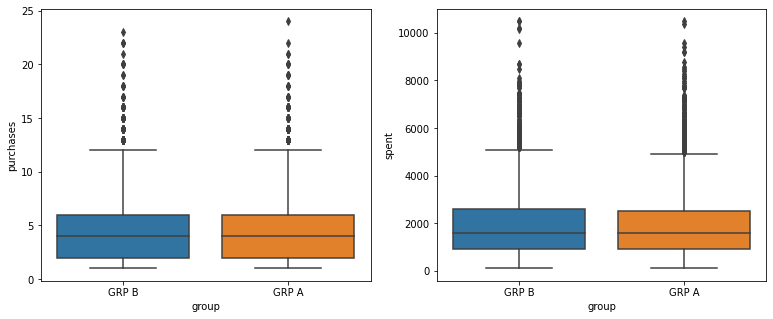

In [26]:
fig, axes = plt.subplots(1, 2, figsize = (13, 5))
sns.boxplot(data = df2, x = 'group', y = 'purchases', ax = axes.ravel()[0]);
sns.boxplot(data = df2, x = 'group', y = 'spent', ax = axes.ravel()[1]);

Apparently, in Brazil there is no clear difference between the groups in terms of purchases and spent value.

## 3.0. Hypothesis Test

### 3.1. Groups

In [15]:
sample_A = df2.query("group == 'GRP A'")['spent'].sample(n = sample_size, random_state = 42)
sample_B = df2.query("group == 'GRP B'")['spent'].sample(n = sample_size, random_state = 42)

# samples metrics
print(f"Avg. Sample A {np.round(sample_A.mean(), 2)} +/- {np.round(sample_A.std(), 2)}")
print(f"Avg. Sample B {np.round(sample_B.mean(), 2)} +/- {np.round(sample_B.std(), 2)}")

Avg. Sample A 1908.56 +/- 1406.42
Avg. Sample B 1902.1 +/- 1383.93


### 3.2. Statistical Inference

In [22]:
z_test, p_value = ttest_ind(sample_A, sample_B)
print(f"p-value: {p_value}")

p-value: 0.8488440918718094


## 4.0. Conclusion

In [ ]:
significance_level = 0.05
if p_value < significance_level:
    print("Reject Null Hypothesis")
    print("Automatic filling brought a significant change in the average GMV of the page")
    print("Use new page")
else:
    print("Fail to Reject Null Hypothesis (Assume Null Hypothesis is true)")
    print("Automatic filling did not bring a significant change in the average GMV of the page")
    print("Rethink new page")

Fail to Reject Null Hypothesis (Assume Null Hypothesis is true)
Automatic filling did not bring a significant change in the average GMV of the page
Rethink new page
